In [1]:
import os
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/home/honda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [109]:
df = pd.read_csv('./data_train.csv')
df.head()

,SMILES,lipid_solubility
0,C1CC(CCC1CCN)O,0.123077
1,C[C@]12CC[C@](C[C@H]1C3=CC(=O)[C@@H]4[C@]5(CC[...,-0.110553
2,C([C@H]([C@H]([C@@H]([C@H](C(=O)O)O)O)O)O)O,-1.454106
3,c1cc(cnc1)C#N,-0.000000
4,C1CC1(C#N)N.Cl,-0.915423


In [111]:
graph_featurizer = dc.feat.graph_features.ConvMolFeaturizer()
loader = dc.data.data_loader.CSVLoader( tasks=['lipid_solubility'], smiles_field="SMILES", featurizer=graph_featurizer )
trainset = loader.featurize( './data_train.csv' )
testset = loader.featurize( './data_test.csv' )

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./data_train.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 1.894 s
TIMING: dataset construction took 2.164 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./data_test.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.778 s
TIMING: dataset construction took 0.880 s
Loading dataset from disk.


In [112]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model = GraphConvModel(n_tasks=1, graph_conv_layers=[128,128], dropout=0, batch_size=50, mode='regression')

# Epochs
model.fit(trainset, nb_epoch=10)

/home/honda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


10.304521579742431

In [113]:
metric = dc.metrics.Metric(
    dc.metrics.r2_score, np.mean, mode="regression")

print("Evaluating model")
train_scores = model.evaluate(trainset, [metric])
print("Train R2 Score: %f" % train_scores["mean-r2_score"])
test_scores = model.evaluate(testset, [metric])
print("Test R2 Score: %f" % test_scores["mean-r2_score"])

Evaluating model
computed_metrics: [0.6150145128090186]
Train R2 Score: 0.615015
computed_metrics: [0.2970404475077223]
Test R2 Score: 0.297040


In [114]:
metric = dc.metrics.Metric(
    dc.metrics.mean_squared_error, np.mean, mode="regression")

print("Evaluating model")
train_scores = model.evaluate(trainset, [metric])
print("Train MSE: %f" % train_scores["mean-mean_squared_error"])
test_scores = model.evaluate(testset, [metric])
print("Test MSE: %f" % test_scores["mean-mean_squared_error"])

Evaluating model
computed_metrics: [0.12170103149957598]
Train MSE: 0.121701
computed_metrics: [0.22527386127965307]
Test MSE: 0.225274


# Another model

In [141]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model2 = GraphConvModel(n_tasks=1, graph_conv_layers=[128,128], dropout=0.4, batch_size=50, mode='regression')
# Epochs
model2.fit(trainset, nb_epoch=500)

metric = dc.metrics.Metric(
    dc.metrics.r2_score, np.mean, mode="regression")
print("Evaluating model")
train_scores = model2.evaluate(trainset, [metric])
print("Train R2 Score: %f" % train_scores["mean-r2_score"])
test_scores = model2.evaluate(testset, [metric])
print("Test R2 Score: %f" % test_scores["mean-r2_score"])

/home/honda/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Evaluating model
computed_metrics: [0.8919744217576396]
Train R2 Score: 0.891974
computed_metrics: [0.14013549278283766]
Test R2 Score: 0.140135


# Plot

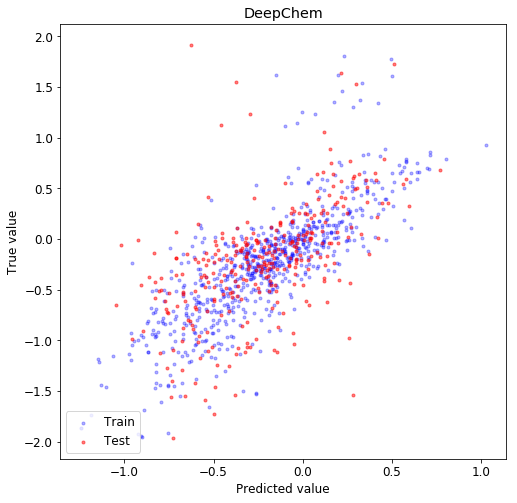

In [115]:
y_train_pred = model.predict(trainset)
y_train = trainset.y
y_pred = model.predict(testset)
y_test = testset.y

plt.figure(figsize=(8,8))
plt.rcParams["font.size"] = 12
plt.scatter(y_train_pred, y_train, c='blue', marker='.', alpha=0.3, label='Train')
plt.scatter(y_pred, y_test, c='red', marker='.', alpha=0.5, label='Test')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title('DeepChem')
plt.legend(loc='lower left')
#plt.hlines(y=0, xmin=1, xmax=7, lw=2, color='black')
plt.show()

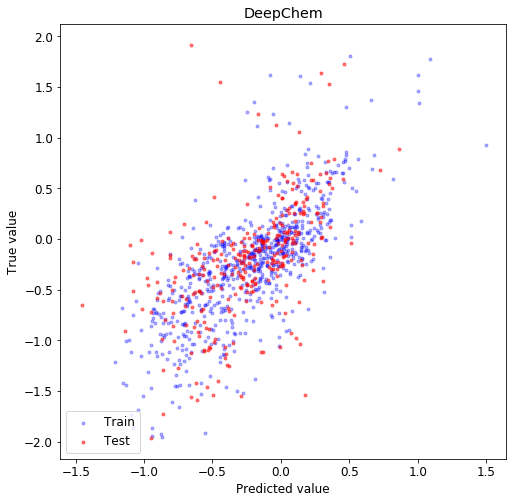

In [140]:
# 2
y_train_pred2 = model2.predict(trainset)
y_train = trainset.y
y_pred2 = model2.predict(testset)
y_test = testset.y

plt.figure(figsize=(8,8))
plt.rcParams["font.size"] = 12
plt.scatter(y_train_pred2, y_train, c='blue', marker='.', alpha=0.3, label='Train')
plt.scatter(y_pred2, y_test, c='red', marker='.', alpha=0.5, label='Test')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title('DeepChem')
plt.legend(loc='lower left')
#plt.hlines(y=0, xmin=1, xmax=7, lw=2, color='black')
plt.show()

In [116]:
print(np.sort(y_pred[:,0])[:-11:-1])
print(y_test[np.argsort(y_pred[:,0])[:-11:-1],0])

[0.76759195 0.59375626 0.5815484  0.56004333 0.5116333  0.477105
 0.45797983 0.4449349  0.4231139  0.4152972 ]
[0.68599034 0.3236715  0.59512195 0.54634146 1.72895863 0.36040609
 0.78743961 0.352657   0.0097561  0.2195122 ]


In [117]:
print(np.sort(y_pred[:,0])[:10])
print(y_test[np.argsort(y_pred[:,0])[:10],0])

[-1.0463861  -1.0218494  -0.95759237 -0.9250305  -0.9062129  -0.8945124
 -0.86144483 -0.8341131  -0.8301604  -0.8263629 ]
[-0.65217391 -0.06091371 -0.98522167 -0.00966184 -0.45410628 -0.90243902
 -0.36945813 -0.1352657  -0.4195122  -0.5862069 ]


In [118]:
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit import RDLogger
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Crippen

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

def render_svg(svg):
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

In [119]:
df_test = pd.read_csv('./data_test.csv')
df_test.head()

,SMILES,lipid_solubility
0,C[N+](C)(C)Cc1ccccc1.[OH-],0.643902
1,CCNCCO,0.285024
2,C/C=C/C=C/C(=O)[O-].[K+],-0.221675
3,C1=CC(=O)OC1=O,-0.668293
4,C(CSSCCN)N.OS(=O)(=O)O,-0.298507


SMILES: CCCCCCCCCCCC(=O)N(C)CC(=O)[O-].[Na+]
LogP -0.8803999999999967
SMILES: CN(CCCN)CCCN
LogP -0.3841999999999987
SMILES: C[C@H](CCC(=O)[O-])[C@H]1CC[C@@H]2[C@@]1([C@H](C[C@H]3[C@H]2CC[C@H]4[C@@]3(CC[C@H](C4)O)C)O)C.[Na+]
LogP 0.147200000000003
SMILES: CCCCCCCCCCCC[NH3+].CC(=O)[O-]
LogP 1.9053999999999995
SMILES: C1CCN(C1)C(=S)S.N
LogP 1.4588999999999999
SMILES: C(CN)CN(CCO)CCO
LogP -1.3781999999999992
SMILES: CCCCCCCCC(=O)O.[NaH]
LogP 2.1731000000000003
SMILES: C(CN)CNCCCN
LogP -0.7263999999999986
SMILES: C(CN)CNCCNCCCN
LogP -1.1367999999999974
SMILES: C(CNCCNCCN)N
LogP -1.916999999999998


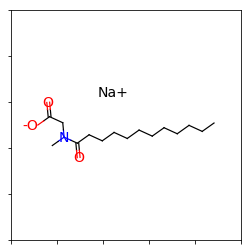

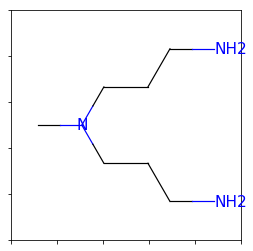

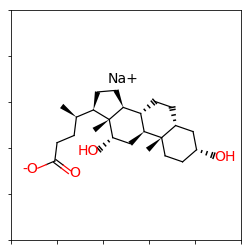

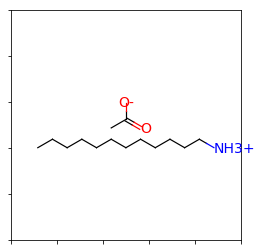

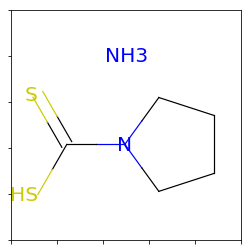

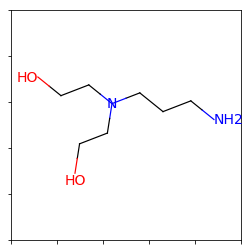

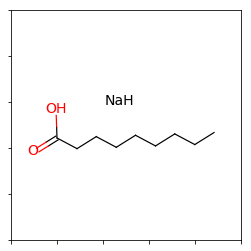

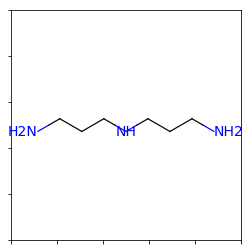

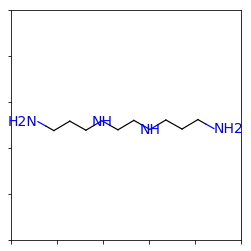

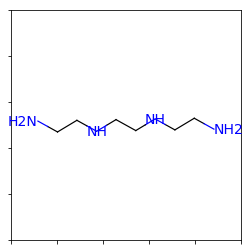

In [120]:
sm_ordered = df_test["SMILES"].values[np.argsort(y_pred[:,0])[::-1]]

for i in range(10):
    print('SMILES:', sm_ordered[i])
    mol = Chem.MolFromSmiles(sm_ordered[i])
    print("LogP", Crippen.MolLogP(mol))
    Chem.Draw.MolToMPL(mol, size=(128, 128))

SMILES: C(CCl)NCCCl.Cl
LogP 1.4754
SMILES: CCOC(=O)C(C(=O)OCC)N.Cl
LogP -0.13829999999999992
SMILES: c1cc[n+](cc1)F.C(F)(F)(F)S(=O)(=O)[O-]
LogP 0.7581000000000003
SMILES: C(C(=O)CCl)Cl
LogP 1.0331
SMILES: C(C(C(=O)O)O)C(=O)O
LogP -1.0934000000000001
SMILES: C1(C(C(OC1C(=O)O)C(=O)O)C(=O)O)C(=O)O
LogP -1.6753999999999998
SMILES: NOS(=O)(=O)O
LogP -1.3204999999999996
SMILES: C[S+](C)CCC(=O)O.[Br-]
LogP -2.6569999999999983
SMILES: CC(CC(=O)O)C(=O)O
LogP 0.18179999999999985
SMILES: C1COC(=O)[C@@H]1N.Cl
LogP -0.31759999999999994


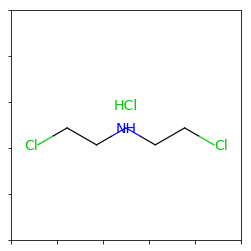

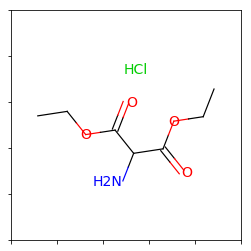

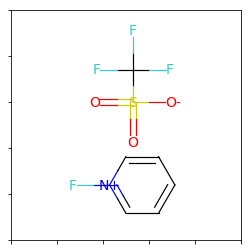

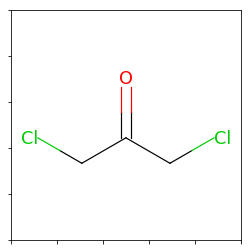

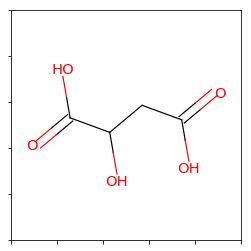

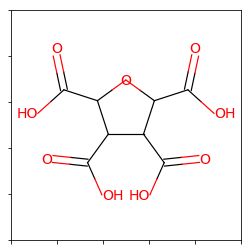

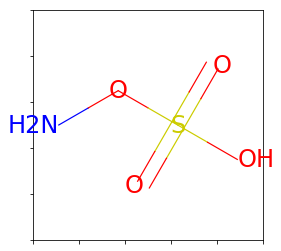

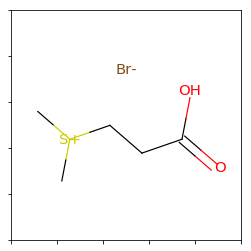

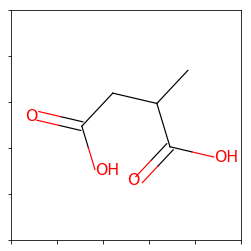

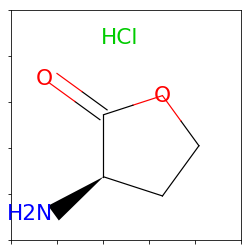

In [121]:
sm_ordered = df_test["SMILES"].values[np.argsort(y_pred[:,0])]

for i in range(10):
    print('SMILES:', sm_ordered[i])
    mol = Chem.MolFromSmiles(sm_ordered[i])
    print("LogP", Crippen.MolLogP(mol))
    Chem.Draw.MolToMPL(mol, size=(128, 128))